# Calibrating Images for Astrometric Measurements

In [1]:
# Imports
from os import listdir
import time
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.config import create_config_file, get_config_dir
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
import numpy as np
from astropy.wcs import Sip
from astropy.coordinates import SkyCoord
from astropy.units import Unit
from astroquery.astrometry_net import AstrometryNet
import pandas as pd
from datetime import datetime, timedelta
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.background import Background2D, MedianBackground
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from twirl import gaia_radecs, compute_wcs
from twirl.geometry import sparsify
import pickle
from astroalign import register, find_transform, matrix_transform
from scipy.spatial import KDTree
from astropy.table import Table

### Astroquery Setup:

Go to https://nova.astrometry.net and sign in.

Copy your API key

Add the following to your config file located at $HOME/.astropy/config/astroquery.cfg

    [astrometry_net]

    ## The Astrometry.net API key.
    api_key =

    ## Name of server
    server = http://nova.astrometry.net

    ## Default timeout for connecting to server
    timeout = 120

In [2]:
create_config_file("astroquery")
print(get_config_dir())

C:\Users\ishum\.astropy\config


## Load + Preprocess All Images

In [2]:
# Set your data Directory where all the vesta exposures are
vestaDataDir = "../Data/VestaData"

# Get the list of the filenames for each exposre time
allFilenames = listdir(vestaDataDir)
filenames_10 = [f for f in allFilenames if f.endswith("10.fit")]
filenames_30 = [f for f in allFilenames if f.endswith("30.fit")]


In [3]:
# Read in the fits files, create a Dictionary mapping filenames to the raw image array,
# as well as metadata dataframes containing filename, DATE_OBS, JD, RA, and DEC
def readFitsFiles(filenames):
    # Create a dictionary to store the data
    dataDict = {}
    # Create a metadata dataframe
    metadata = pd.DataFrame(columns=["Filename", "DATE-OBS", "JD", "RA", "DEC"])
    # Loop through the filenames
    for filename in filenames:
        # Read in the fits file
        with fits.open(vestaDataDir + "/" + filename) as hdul:
            # Parse the RA value to a datetime object
            ra_datetime = datetime.strptime(hdul[0].header["RA"], "%H:%M:%S.%f")
            # Add one hour
            ra_datetime += timedelta(hours=1)
            # Format it back to a string
            new_ra = ra_datetime.strftime("%H:%M:%S.%f")
            # Append the metadata to the dataframe
            metadata = pd.concat([metadata, pd.DataFrame({
                "Filename": [filename], 
                "DATE-OBS": [hdul[0].header["DATE-OBS"]], 
                "JD": [hdul[0].header["JD"]], 
                "RA": [new_ra],
                "DEC": [hdul[0].header["DEC"]],
                "Width": [hdul[0].header["NAXIS1"]],
                "Height": [hdul[0].header["NAXIS2"]]
            })], ignore_index=True)
            # Add the data to the dictionary
            dataDict[filename] = hdul[0].data
    # Return the data dictionary and the metadata dataframe
    return dataDict, metadata

# Read in the fits files
dataDict_10, metaData_10 = readFitsFiles(filenames_10)
dataDict_30, metaData_30 = readFitsFiles(filenames_30)

C:\Users\ishum\AppData\Local\Temp\ipykernel_19348\2631679277.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metadata = pd.concat([metadata, pd.DataFrame({
C:\Users\ishum\AppData\Local\Temp\ipykernel_19348\2631679277.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metadata = pd.concat([metadata, pd.DataFrame({


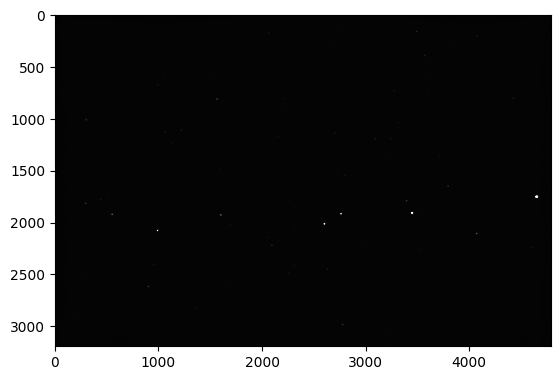

In [23]:
# Test plot one of the images
plt.imshow(dataDict_10[filenames_10[0]], cmap="gray", vmax=5000)
plt.show()


In [5]:
# Display the metadata
print("10s Exposure Metadata")
print(metaData_10)
print("30s Exposure Metadata")
print(metaData_30)

10s Exposure Metadata
            Filename                 DATE-OBS            JD               RA  \
0  vesta-0831-10.fit  2024-03-14T01:30:59.864  2.460384e+06  05:40:06.000000   
1  vesta-0835-10.fit  2024-03-14T01:35:00.304  2.460384e+06  05:40:06.000000   
2  vesta-0838-10.fit  2024-03-14T01:38:00.214  2.460384e+06  05:40:06.000000   
3  vesta-0841-10.fit  2024-03-14T01:41:00.599  2.460384e+06  05:40:06.000000   
4  vesta-0844-10.fit  2024-03-14T01:44:00.196  2.460384e+06  05:40:06.000000   
5  vesta-0847-10.fit  2024-03-14T01:47:00.049  2.460384e+06  05:40:06.000000   
6  vesta-0850-10.fit  2024-03-14T01:50:00.310  2.460384e+06  05:40:06.000000   
7  vesta-0853-10.fit  2024-03-14T01:53:00.209  2.460384e+06  05:40:06.000000   
8  vesta-0858-10.fit  2024-03-14T01:56:00.356  2.460384e+06  05:40:06.000000   

         DEC   Width  Height  
0  +24:01:00  4788.0  3194.0  
1  +24:00:00  4788.0  3194.0  
2  +24:00:00  4788.0  3194.0  
3  +24:00:00  4788.0  3194.0  
4  +24:00:00  4788.0  

In [4]:
# For each image data in the dictionary, Subtract the background
# Use some of the values that worked well in the previous lab using Sigma clipping and Background2d
# Take a Take a datadict and modify each image in place
def subtractBackground(dataDict):
    # create background estimator
    box_size = (50, 50)
    filter_size = (7, 7)
    sigma_clip = SigmaClip(sigma=5.0, maxiters=None)
    bkg_estimator = MedianBackground()
    # Loop through the data dictionary
    for filename, data in dataDict.items():
        # Subtract the background
        dataDict[filename] = data - Background2D(
            data,
            box_size,
            filter_size=filter_size,
            sigma_clip=sigma_clip,
            bkg_estimator=bkg_estimator
        ).background
    # Return the modified data dictionary
    return dataDict

# Subtract the background from the images
dataDict_10 = subtractBackground(dataDict_10)
dataDict_30 = subtractBackground(dataDict_30)

## Calculate WCS for each Image

### Astrometry.net Via Astroquery, with and without SIP solution

Astroquery offers a "solve_from_image" that automatically applies DAOStarfind to extract source positions, then send that, since it is quicker than actually uploading the image. However, it defaults to using the FITS header For the RA and DEC, which we have to correct. Also, since I applied background subtraction, I would have to then save the data back to a fits file, then pass the filename to the astroquery function, which you can also give args to control the star find algorithm.

Since I already have the data, I'm going to apply the DAO starfind algorithm myself, then pass the source list to "solve_from_source_list"

It also needs some configureation to specify the angular size of the image, so astrometry.net runs quicker.

In [15]:
### THIS CELL TAKES A WHILE TO RUN, 4m on my machine ###

# Had to tweak fwhm to 10.0 to get the bright stars to match.

# Apply DAOStarfinder to each image in the data dictionary using fwhm=20.0, and threshold=8.*std,
# and sigma_clipped_stats with sigma=5.0, and maxiters=None
# Take the 20 brightest stars by flux, discard the rest, sort the table by decreasing flux order
# Return a dictionary of tables
def applyDAOStarFinder(dataDict):
    # Create a dictionary to store the tables
    tableDict = {}
    # Loop through the data dictionary
    for filename, data in dataDict.items():
        # Get the mean, median, and std of the data
        _, _, std = sigma_clipped_stats(data, sigma=5.0, maxiters=None)
        # Create a DAOStarFinder object
        daofind = DAOStarFinder(fwhm=10.0, threshold=8.*std)
        # Find the stars
        sources = daofind(data)
        # Sort the sources by flux
        sources.sort("flux")
        sources.reverse()
        # Add the table to the dictionary
        tableDict[filename] = sources
    # Return the table dictionary
    return tableDict


In [ ]:
# Apply DAOStarFinder to the images
tableDict_10 = applyDAOStarFinder(dataDict_10)[:20]
tableDict_30 = applyDAOStarFinder(dataDict_30)[:20]

In [8]:
# preview one of the tables
print("10s Exposure Table")
print(tableDict_10[filenames_10[0]])

10s Exposure Table
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
116  4638.265484508395 ... 2111.9789163359205  -8.311723945917846
125  549.8061547381519 ... 145.74143182971488  -5.408957579787662
126   1596.67758880074 ...  134.6561485627781   -5.32306547153037
135 4061.7691766641115 ... 113.63392718619997 -5.1387700403640615
119 294.87310521447586 ...  75.38727978618681  -4.693245182157693
171  899.4851423602258 ...  74.39924879787644 -4.6789213763450705
 76 300.64547275468044 ...  66.09120334994682  -4.550359148305368
108 3786.4889613913206 ...  63.03927196943189  -4.499027972280677
 17 3482.9426892447264 ...  53.57346453550325  -4.322374331537854
 34 3561.9452829317815 ...  40.19196410157531  -4.010348074551594
 90  3084.453162817174 ...  38.67954422624406  -3.968703370016979
 80  1215.990845477509 ...  34.00654034011894 -3.8289061279336796
 83 1063.6111169473613 ...  32.95398058873161 -3.79476970

In [9]:
### This takes a verrry long time to run, took about 30m for me ###

# query astrometry.net using astroquery and AstrometryNet
# Take a table of sources, and a metadata dataframe
# Return a dictionary of results
# should wait 30 seconds between queries, after the last one has returned successfully
def queryAstrometryNet(table, metadata, use_sip=True):
    # Create a dictionary to store the results
    resultsDict = {}
    # Create an AstrometryNet object
    ast = AstrometryNet()
    # Loop through the tables
    for filename, sources in table.items():
        # Get the metadata for the filename
        metadataRow = metadata[metadata["Filename"] == filename].iloc[0]
        # Get the RA and DEC, converted to Degrees
        center = SkyCoord(metadataRow["RA"], metadataRow["DEC"], unit=(Unit("hourangle"), Unit("degree")))
        ra = center.ra.deg
        dec = center.dec.deg
        # Solve the astrometry
        result = ast.solve_from_source_list(
            sources["xcentroid"],
            sources["ycentroid"],
            metadataRow["Width"],
            metadataRow["Height"],
            center_ra=ra,   # Estimated center of the image RA
            center_dec=dec, # Estimated center of the image DEC
            radius=1.0,     # Radius of possible error of center of image in degrees
            scale_type="ul",        # Estimate of scale of image, upper and lower bounds
            scale_units="degwidth", # Units of scale, width of field image in degrees
            scale_lower=0.1,        # Lower bound of image width in degrees
            scale_upper=1.0,        # Upper bound of image width in degrees
            parity=2,          # whether the image is mirrored, not sure, so check both
            solve_timeout=300, # Timeout for solving
            crpix_center=True, # Center the image at the center of the image
            tweak_order=2 if use_sip else 0 # Use SIP distortion correction optionally
        )
        # Add the result to the dictionary
        resultsDict[filename] = result
        # Wait 30 seconds
        print("Waiting 30 seconds")
        time.sleep(30.0)
    # Return the results dictionary
    return resultsDict

# Query Astrometry.net for the tables, with and without SIP
resultsDict_10_SIP = queryAstrometryNet(tableDict_10, metaData_10, use_sip=True)
resultsDict_30_SIP = queryAstrometryNet(tableDict_30, metaData_30, use_sip=True)
resultsDict_10_NoSIP = queryAstrometryNet(tableDict_10, metaData_10, use_sip=False)
resultsDict_30_NoSIP = queryAstrometryNet(tableDict_30, metaData_30, use_sip=False)

Solving..............Waiting 30 seconds
Solving..........Waiting 30 seconds
Solving..................Waiting 30 seconds
Solving.............................................................................Waiting 30 seconds
Solving.......................Waiting 30 seconds
Solving........Waiting 30 seconds
Solving...........Waiting 30 seconds
Solving............Waiting 30 seconds
Solving......................Waiting 30 seconds
Solving..........................................................................................................................................Waiting 30 seconds
Solving............................Waiting 30 seconds
Solving................................................................................................Waiting 30 seconds
Solving............Waiting 30 seconds
Solving..............Waiting 30 seconds
Solving.........Waiting 30 seconds
Solving......................Waiting 30 seconds
Solving.........Waiting 30 seconds
Solving..........Waiting 30 seconds

In [17]:
# Peek at the one of the results
print("10s Exposure Results")
print(repr(resultsDict_10_NoSIP[filenames_10[0]]))

10s Exposure Results
SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN' / TAN (gnomic) projection                                  
CTYPE2  = 'DEC--TAN' / TAN (gnomic) projection                                  
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        85.1730166391 / RA  of reference point                         
CRVAL2  =        24.0279559122 / DEC of reference point                         
CRPIX1 

In [12]:
# Cache the results since the querying takes a long time
# pickle the dictionaries into a data folder
queryResultsFolder = "../Data/VestaData/AstroNetqueryResults"
pickle.dump(resultsDict_10_SIP, open(queryResultsFolder + "/resultsDict_10_SIP.pkl", "wb"))
pickle.dump(resultsDict_30_SIP, open(queryResultsFolder + "/resultsDict_30_SIP.pkl", "wb"))
pickle.dump(resultsDict_10_NoSIP, open(queryResultsFolder + "/resultsDict_10_NoSIP.pkl", "wb"))
pickle.dump(resultsDict_30_NoSIP, open(queryResultsFolder + "/resultsDict_30_NoSIP.pkl", "wb"))

In [ ]:
# Commented out unless needed: reload the cached results
# resultsDict_10_SIP = pickle.load(open(queryResultsFolder + "/resultsDict_10_SIP.pkl", "rb"))
# resultsDict_30_SIP = pickle.load(open(queryResultsFolder + "/resultsDict_30_SIP.pkl", "rb"))
# resultsDict_10_NoSIP = pickle.load(open(queryResultsFolder + "/resultsDict_10_NoSIP.pkl", "rb"))
# resultsDict_30_NoSIP = pickle.load(open(queryResultsFolder + "/resultsDict_30_NoSIP.pkl", "rb"))

In [16]:
# Construct astropy WCS objects from the results
# Take the results dictionary of HDU results from AStrometry.net
# Return a dictionary of WCS objects
def constructWCS_FromAstroNet(resultsDict):
    # Create a dictionary to store the WCS objects
    wcsDict = {}
    # Loop through the results dictionary
    for filename, result in resultsDict.items():
        wcsDict[filename] = WCS(result)
    # Return the WCS dictionary
    return wcsDict

# Construct the WCS objects from the results
wcsDict_10_SIP = constructWCS_FromAstroNet(resultsDict_10_SIP)
wcsDict_30_SIP = constructWCS_FromAstroNet(resultsDict_30_SIP)
wcsDict_10_NoSIP = constructWCS_FromAstroNet(resultsDict_10_NoSIP)
wcsDict_30_NoSIP = constructWCS_FromAstroNet(resultsDict_30_NoSIP)

### Twirl Solution

In [69]:
### Takes a long time to run, took about 9minutes for me ###

# Use the twirl library to generate WCS from querying the Gaia catalog
# assume fov (in degrees), is about 1.0, pull center from metadata dataframe
# Take a dictionary of extracted sources, and a metadata dataframe, and a fov
# Return a dictionary of WCS objects
def generateWCS(sourceDict, metadata, fov=0.6):
    # Create a dictionary to store the WCS objects
    twirlWCSDict = {}

    # Get the center of the image from the first metadata row
    metadataRow = metadata.iloc[0]
    center = SkyCoord(metadataRow["RA"], metadataRow["DEC"], unit=(Unit("hourangle"), Unit("degree")))

    # Query Gaia for star positions
    radecs = gaia_radecs(center, fov)

    # Loop through the results dictionary
    for filename, result in sourceDict.items():
        # construct nd array of xy coordinates of found sources from astropy table
        xy = np.column_stack((result["xcentroid"], result["ycentroid"]))

        # construct the WCS object
        # I think the returns from the Gaia query are sorted from brightness down, so we can use the first few
        wcs = compute_wcs(xy, radecs[0:50], tolerance=5.0)
        
        # Add the WCS object to the dictionary
        twirlWCSDict[filename] = wcs

    # Return the WCS dictionary
    return twirlWCSDict

# Generate the WCS objects from the sources
twirlWCSDict_10 = generateWCS(tableDict_10, metaData_10)
twirlWCSDict_30 = generateWCS(tableDict_30, metaData_30)

NameError: name 'tableDict_10' is not defined

## Calculate Error in Each Method.

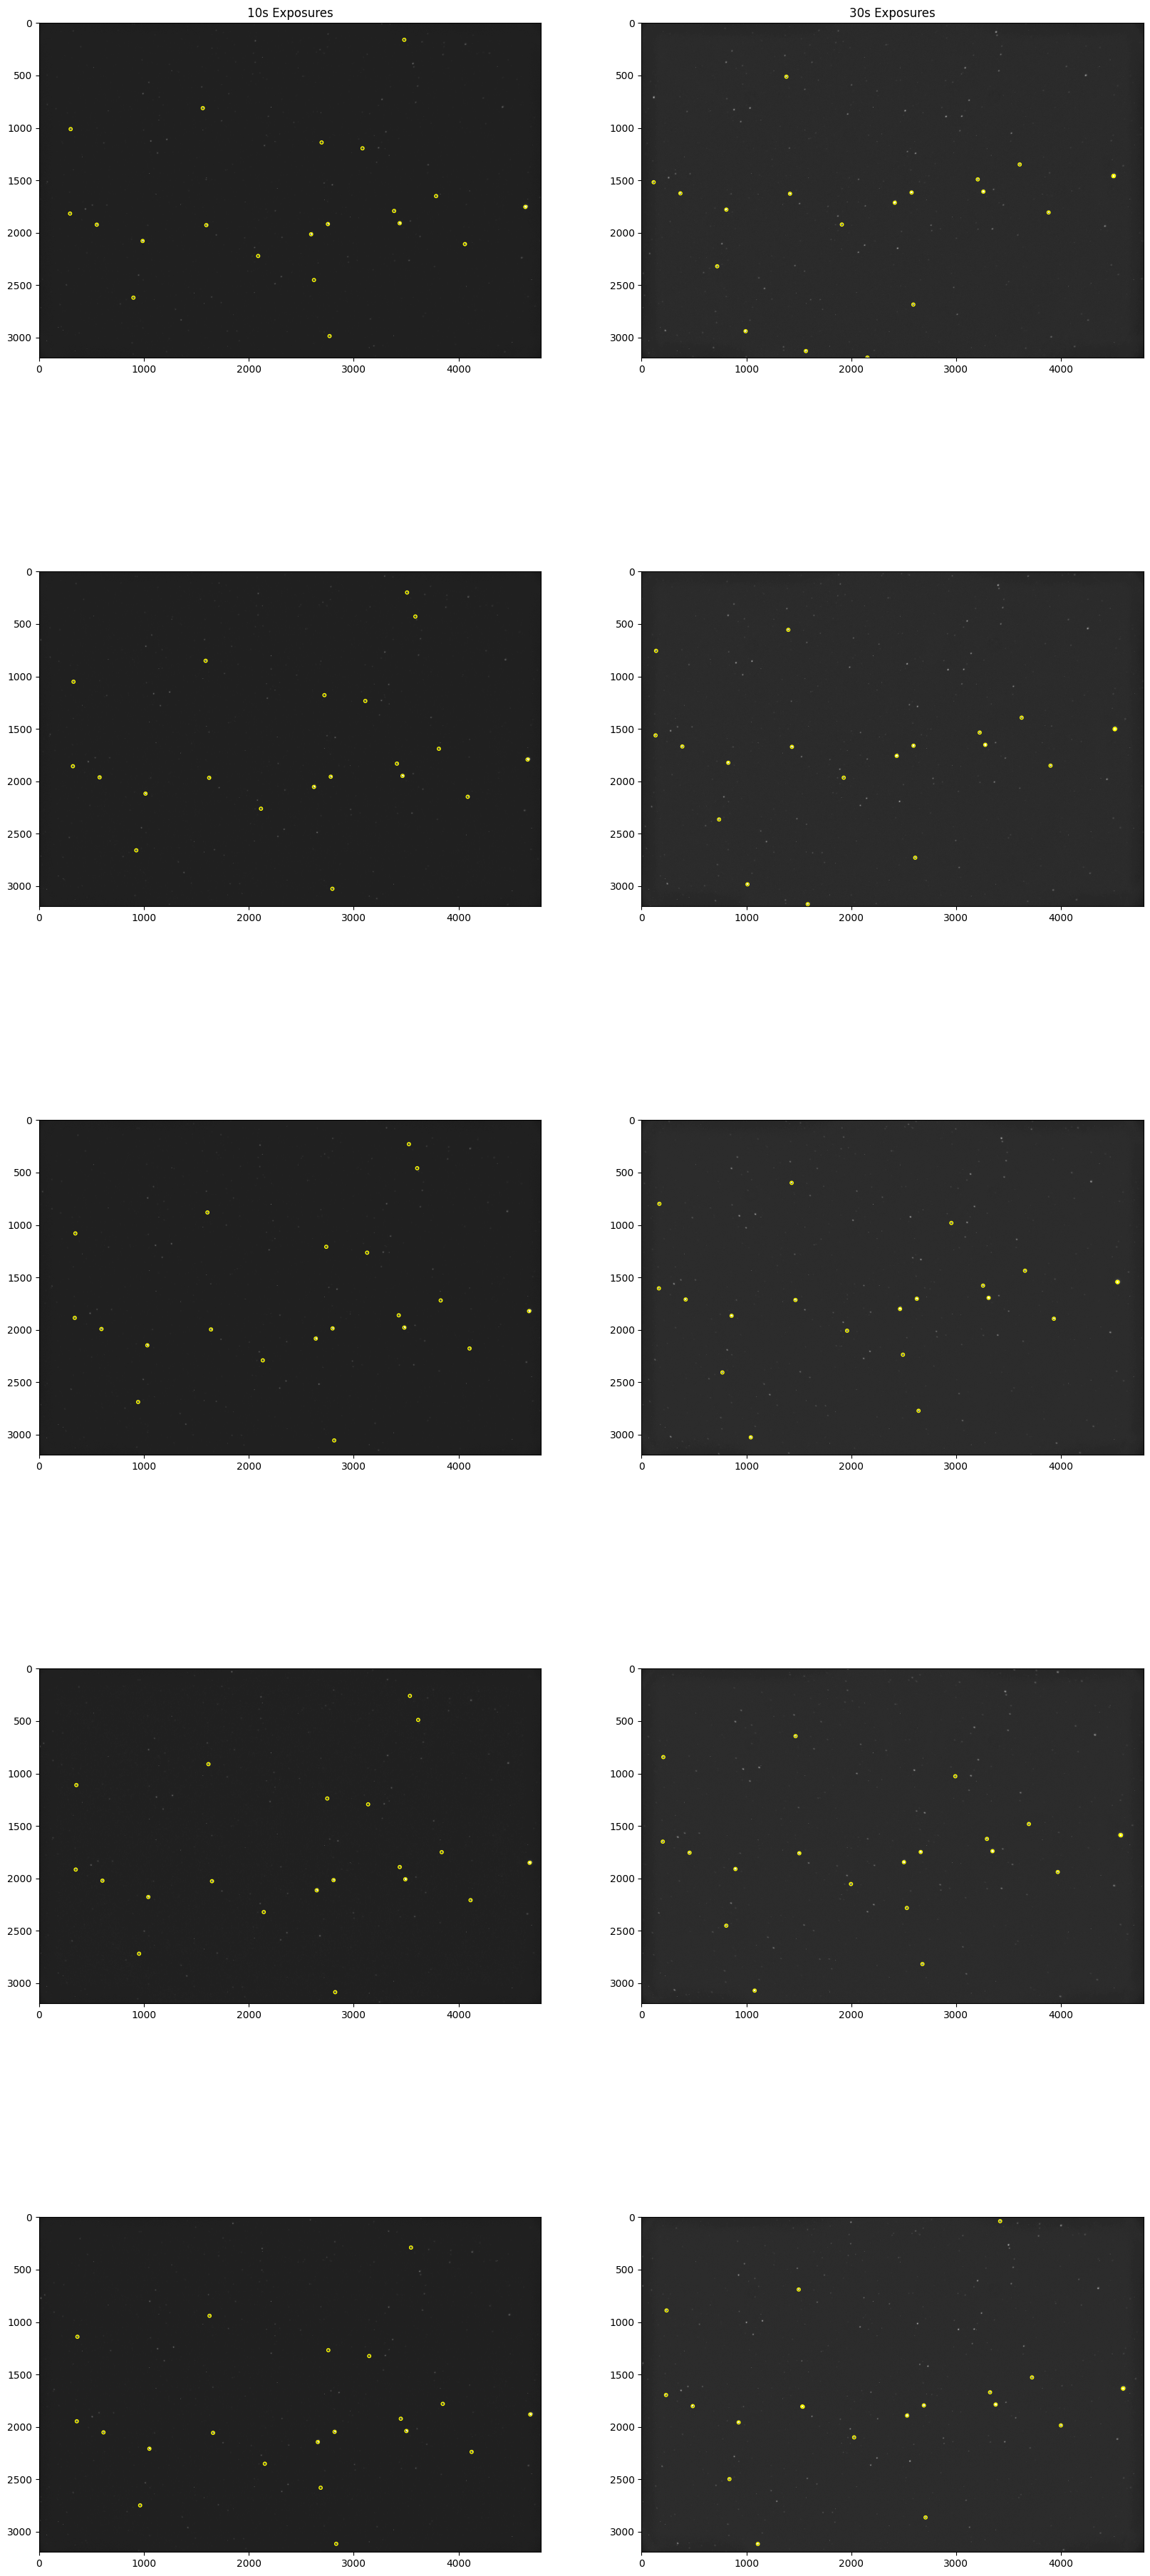

In [38]:
# Define a function to plot the images
# This also plots the found sources from our images
def plot_images(filenames, dataDict, tableDict, ax, title):
    # Loop through the first 5 filenames
    for i, filename in enumerate(filenames[:5]):
        # Get the image data
        data = dataDict[filename]
        # Get the table of sources
        sources = tableDict[filename]

        # Create a stretch
        norm = ImageNormalize(stretch=SqrtStretch(), vmax=5000, clip=True)
        # Display the image
        ax[i].imshow(data, cmap="gray", norm=norm)
        # Loop through the sources
        for source in sources:
            # Create a circular aperture
            aperture = CircularAperture((source["xcentroid"], source["ycentroid"]), 15)
            # Plot the aperture
            aperture.plot(ax[i], color="yellow")

        # Set the title for the first plot in each column
        if i == 0:
            ax[i].set_title(title)

# Create a figure with 10 subplots
fig, ax = plt.subplots(5, 2, figsize=(20, 50))

# Adjust the vertical spacing
fig.subplots_adjust(hspace=0.0)

# Plot the first 5 images from the 10s exposures
plot_images(filenames_10, dataDict_10, tableDict_10, ax[:,0], "10s Exposures")

# Plot the first 5 images from the 30s exposures
plot_images(filenames_30, dataDict_30, tableDict_30, ax[:,1], "30s Exposures")

# Show the plot
plt.show()

In [45]:
# Get RA and Dec of some Gaia stars in the location of our image
# Use the first metadata row to get the center
metadataRow = metaData_10.iloc[0]
center = SkyCoord(metadataRow["RA"], metadataRow["DEC"], unit=(Unit("hourangle"), Unit("degree")))
# Query Gaia for star positions
radecs = gaia_radecs(center, 0.6)
# sparse the radecs
radecs = sparsify(radecs, 0.02)
# Get the first 50 (should be brightest?)
radecs = radecs[0:50]

I noticed while tweaking the gaia_radecs query, that the center seems to be to the right in my image,
also it tries to plot stars outside the bounds of the axes, going to have to manually limit that.

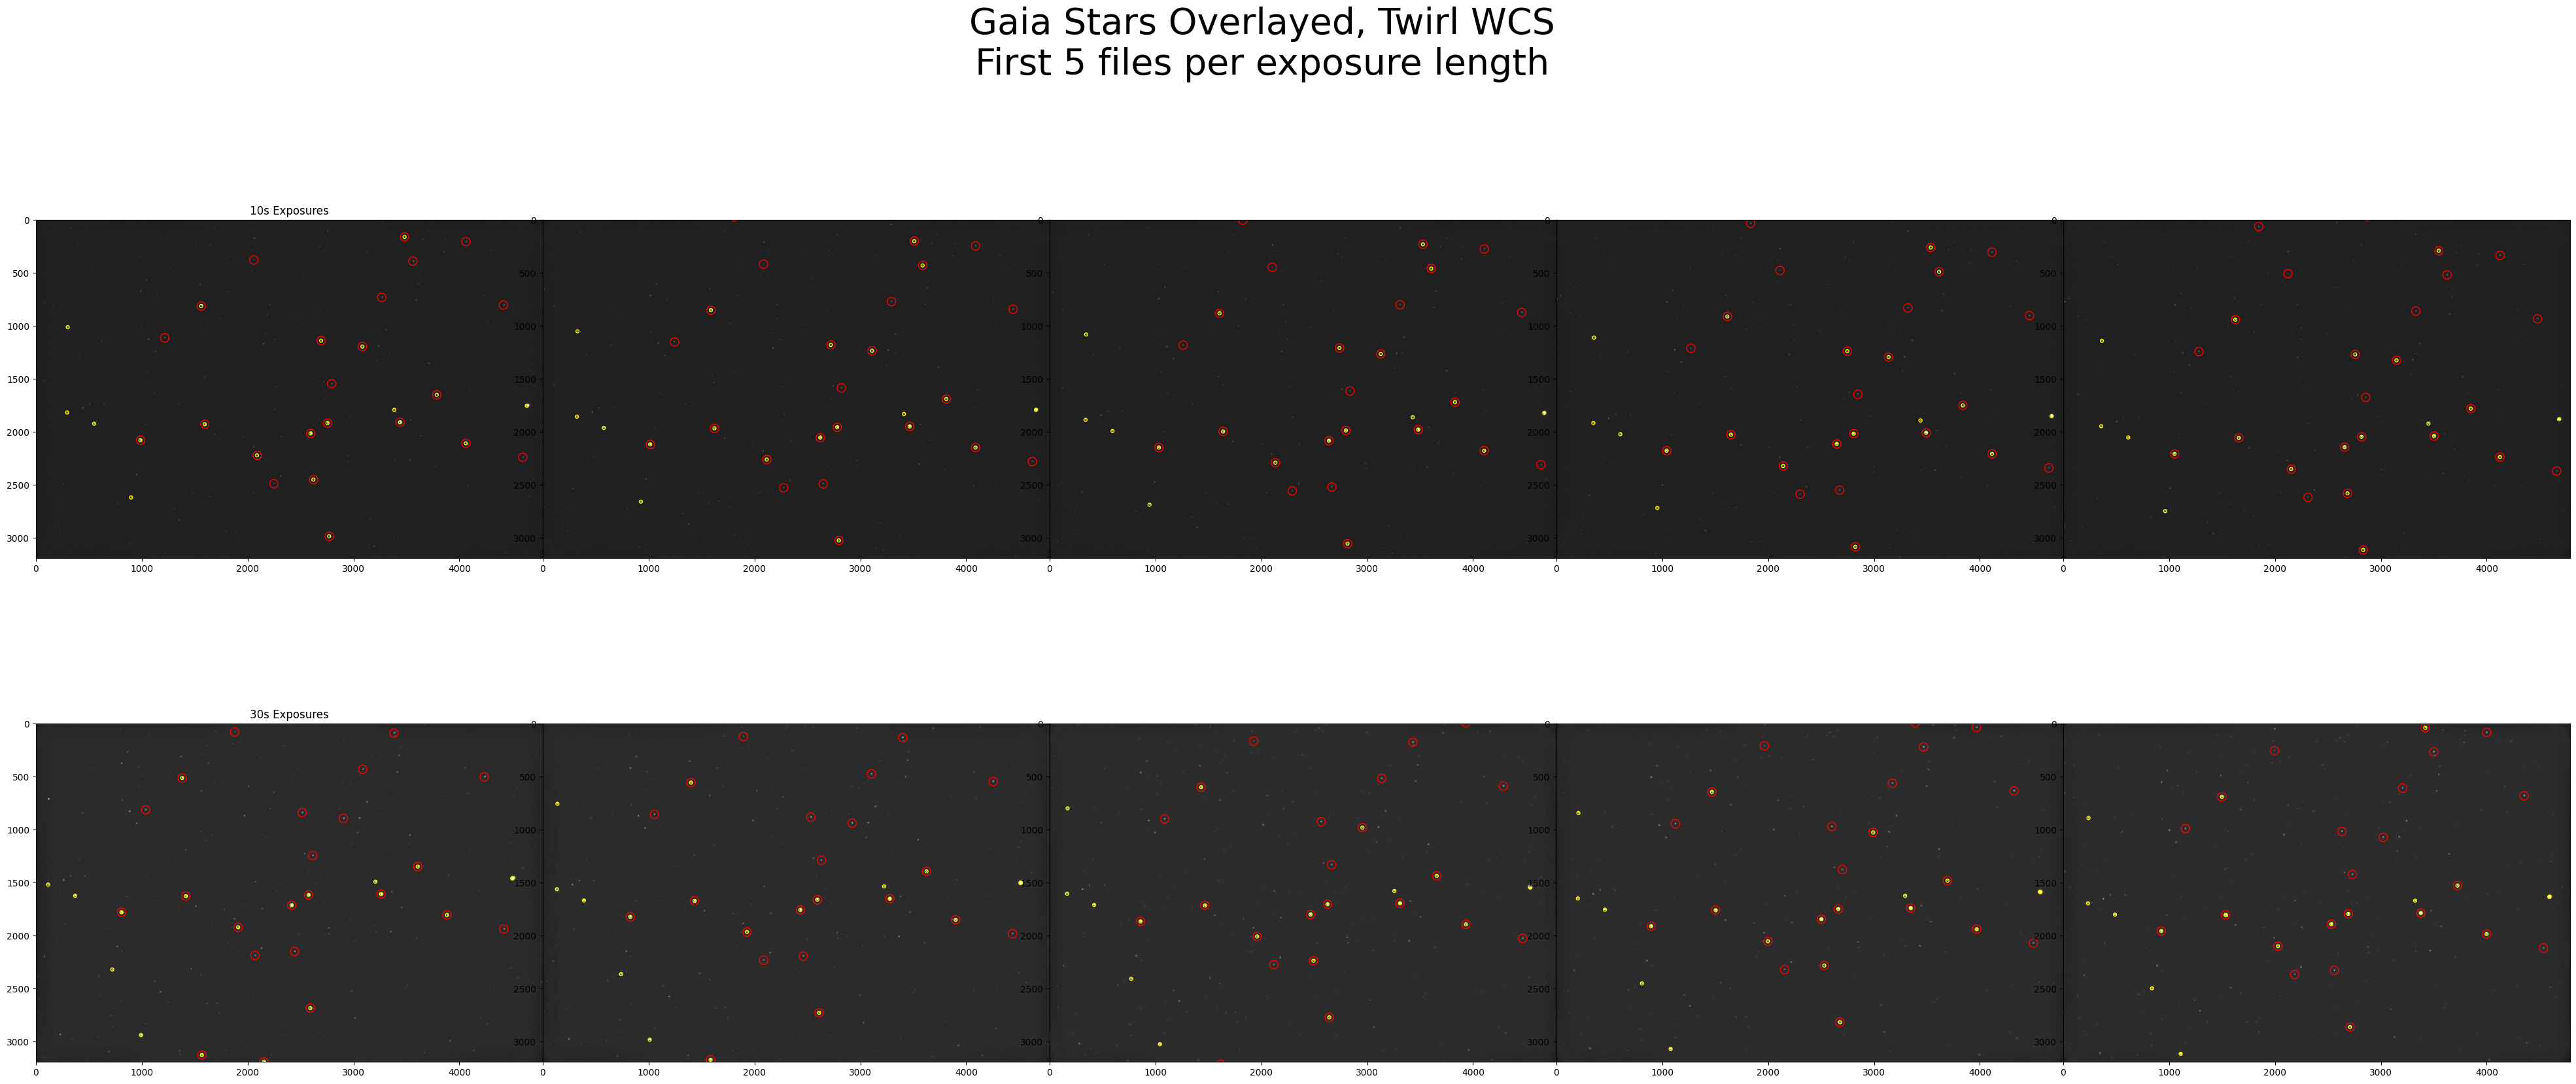

In [53]:
# Create a figure with 2 subplots
fig, ax = plt.subplots(2, 5, figsize=(50, 20))

# Adjust the horizontal spacing
fig.subplots_adjust(wspace=0.0, hspace=0.0)

# Plot the first 5 images from the 10s exposures
plot_images(filenames_10, dataDict_10, tableDict_10, ax[0,:], "10s Exposures")

# Plot the first 5 images from the 30s exposures
plot_images(filenames_30, dataDict_30, tableDict_30, ax[1,:], "30s Exposures")

# Loop through the first 5 filenames
for i, filename in enumerate(filenames_10[:5]):
    # Get the WCS object
    wcs = twirlWCSDict_10[filename]
    # Loop through the Gaia stars
    for radec in radecs:
        # Convert the RA and Dec to pixel coordinates
        x, y = wcs.all_world2pix(radec[0], radec[1], 0)
        # Plot the star using an aperture
        aperture = CircularAperture((x, y), 40)
        aperture.plot(ax[0, i], color="red")

# Loop through the first 5 filenames
for i, filename in enumerate(filenames_30[:5]):
    # Get the WCS object
    wcs = twirlWCSDict_30[filename]
    # Loop through the Gaia stars
    for radec in radecs:
        # Convert the RA and Dec to pixel coordinates
        x, y = wcs.all_world2pix(radec[0], radec[1], 0)
        # Plot the star using an aperture
        aperture = CircularAperture((x, y), 40)
        aperture.plot(ax[1, i], color="red")

# Add Super title
fig.suptitle("Gaia Stars Overlayed, Twirl WCS\nFirst 5 files per exposure length", fontsize=40)
# Show the plot
plt.show()

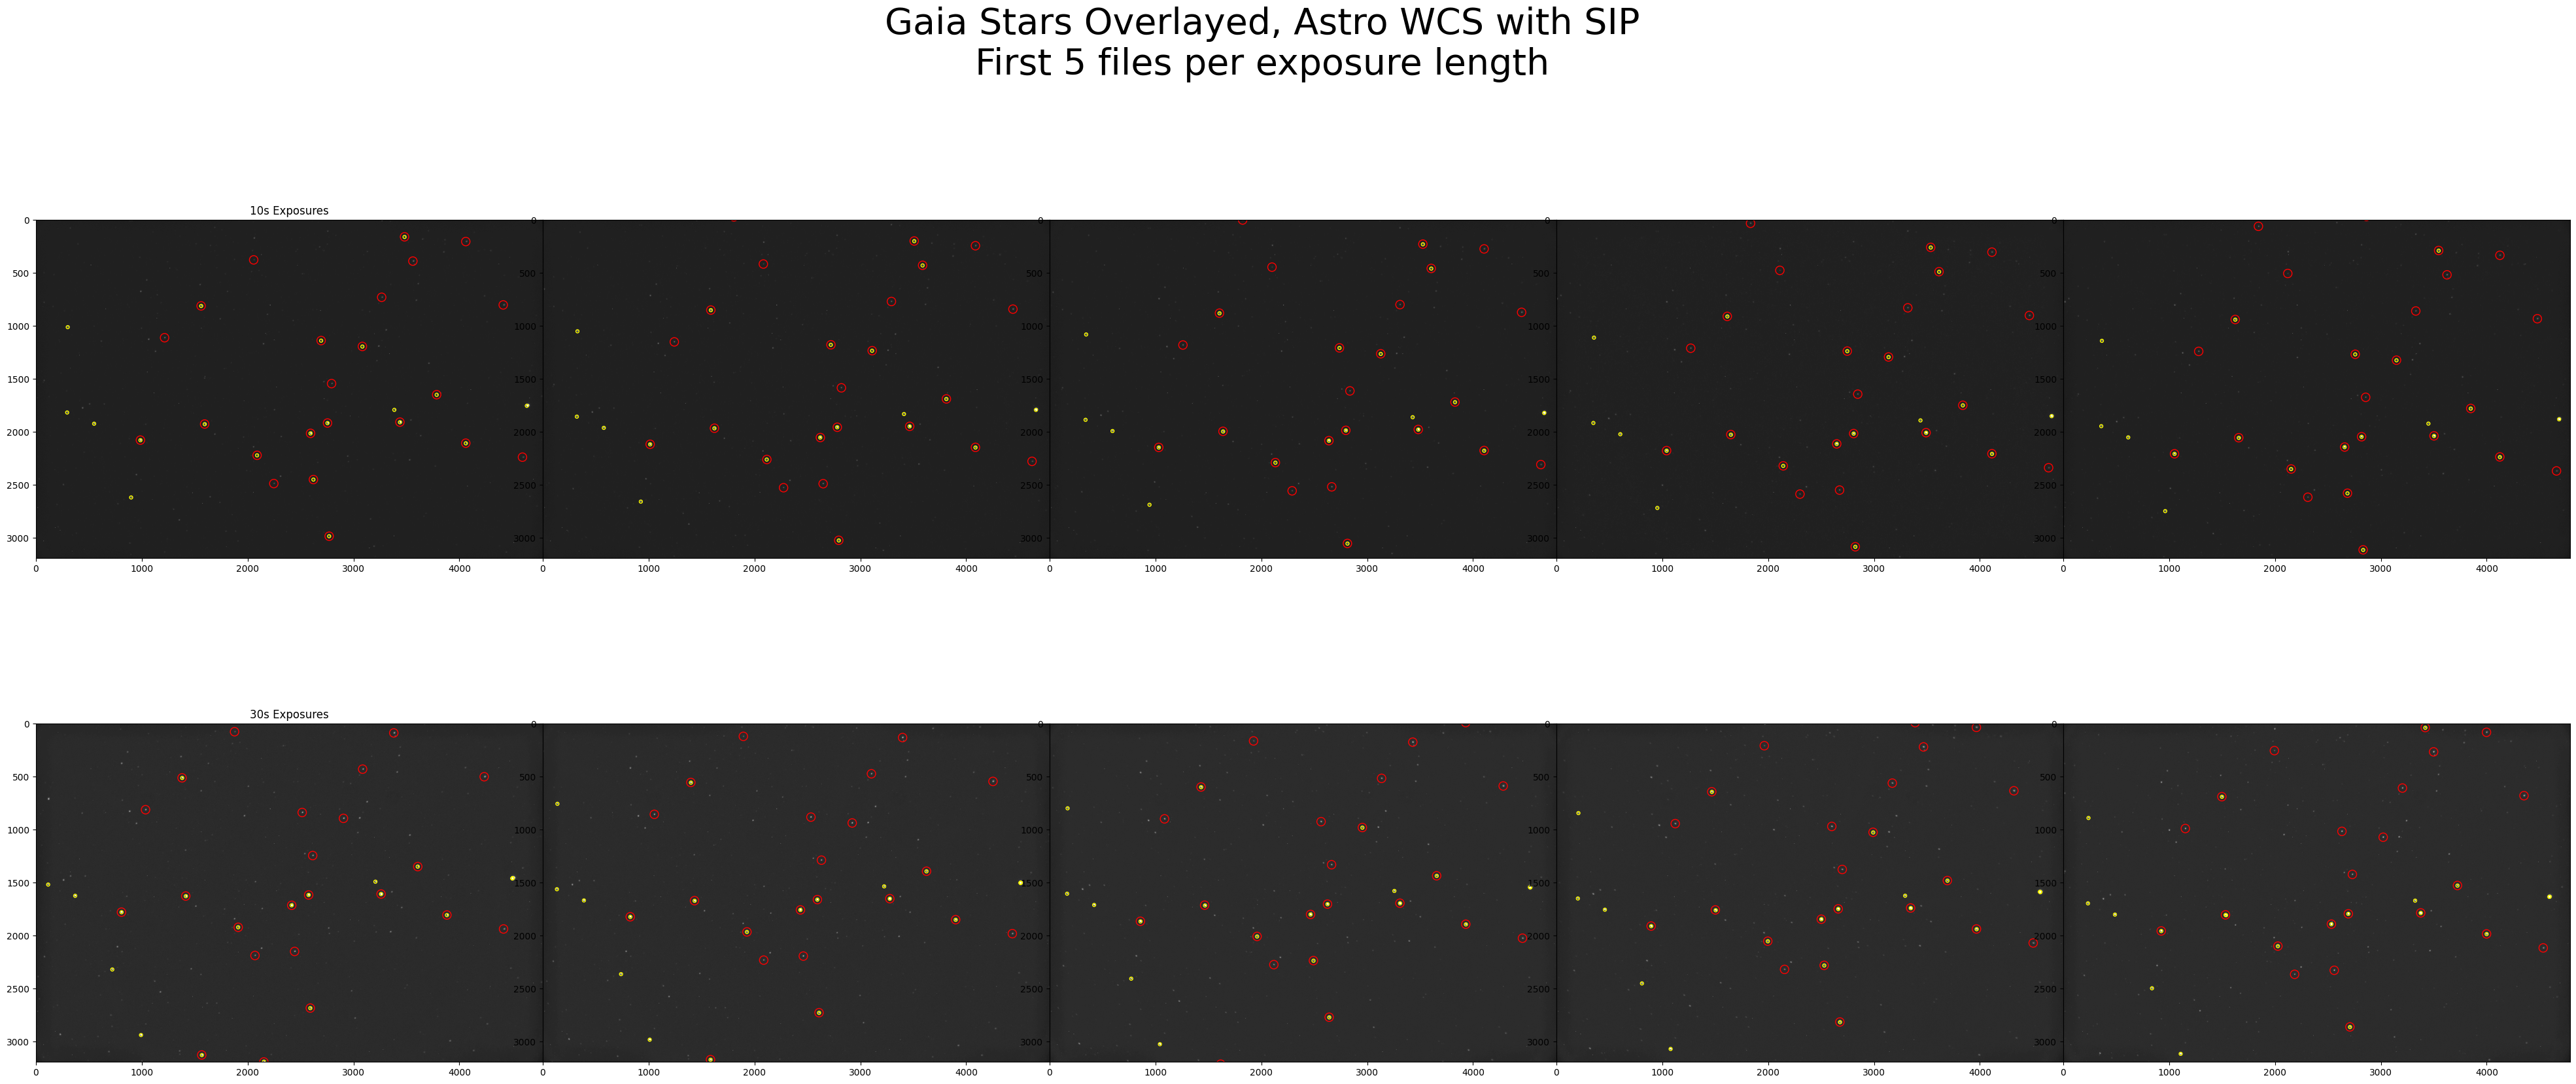

In [51]:
# Create a figure with 2 subplots
fig, ax = plt.subplots(2, 5, figsize=(50, 20))

# Adjust the horizontal spacing
fig.subplots_adjust(wspace=0.0, hspace=0.0)

# Plot the first 5 images from the 10s exposures
plot_images(filenames_10, dataDict_10, tableDict_10, ax[0,:], "10s Exposures")

# Plot the first 5 images from the 30s exposures
plot_images(filenames_30, dataDict_30, tableDict_30, ax[1,:], "30s Exposures")

# Loop through the first 5 filenames
for i, filename in enumerate(filenames_10[:5]):
    # Get the WCS object
    wcs = wcsDict_10_SIP[filename]
    # Loop through the Gaia stars
    for radec in radecs:
        # Convert the RA and Dec to pixel coordinates
        x, y = wcs.all_world2pix(radec[0], radec[1], 0)
        # Plot the star using an aperture
        aperture = CircularAperture((x, y), 40)
        aperture.plot(ax[0, i], color="red")

# Loop through the first 5 filenames
for i, filename in enumerate(filenames_30[:5]):
    # Get the WCS object
    wcs = wcsDict_30_SIP[filename]
    # Loop through the Gaia stars
    for radec in radecs:
        # Convert the RA and Dec to pixel coordinates
        x, y = wcs.all_world2pix(radec[0], radec[1], 0)
        # Plot the star using an aperture
        aperture = CircularAperture((x, y), 40)
        aperture.plot(ax[1, i], color="red")

# Add Super title
fig.suptitle("Gaia Stars Overlayed, Astro WCS with SIP\nFirst 5 files per exposure length", fontsize=40)
# Show the plot
plt.show()

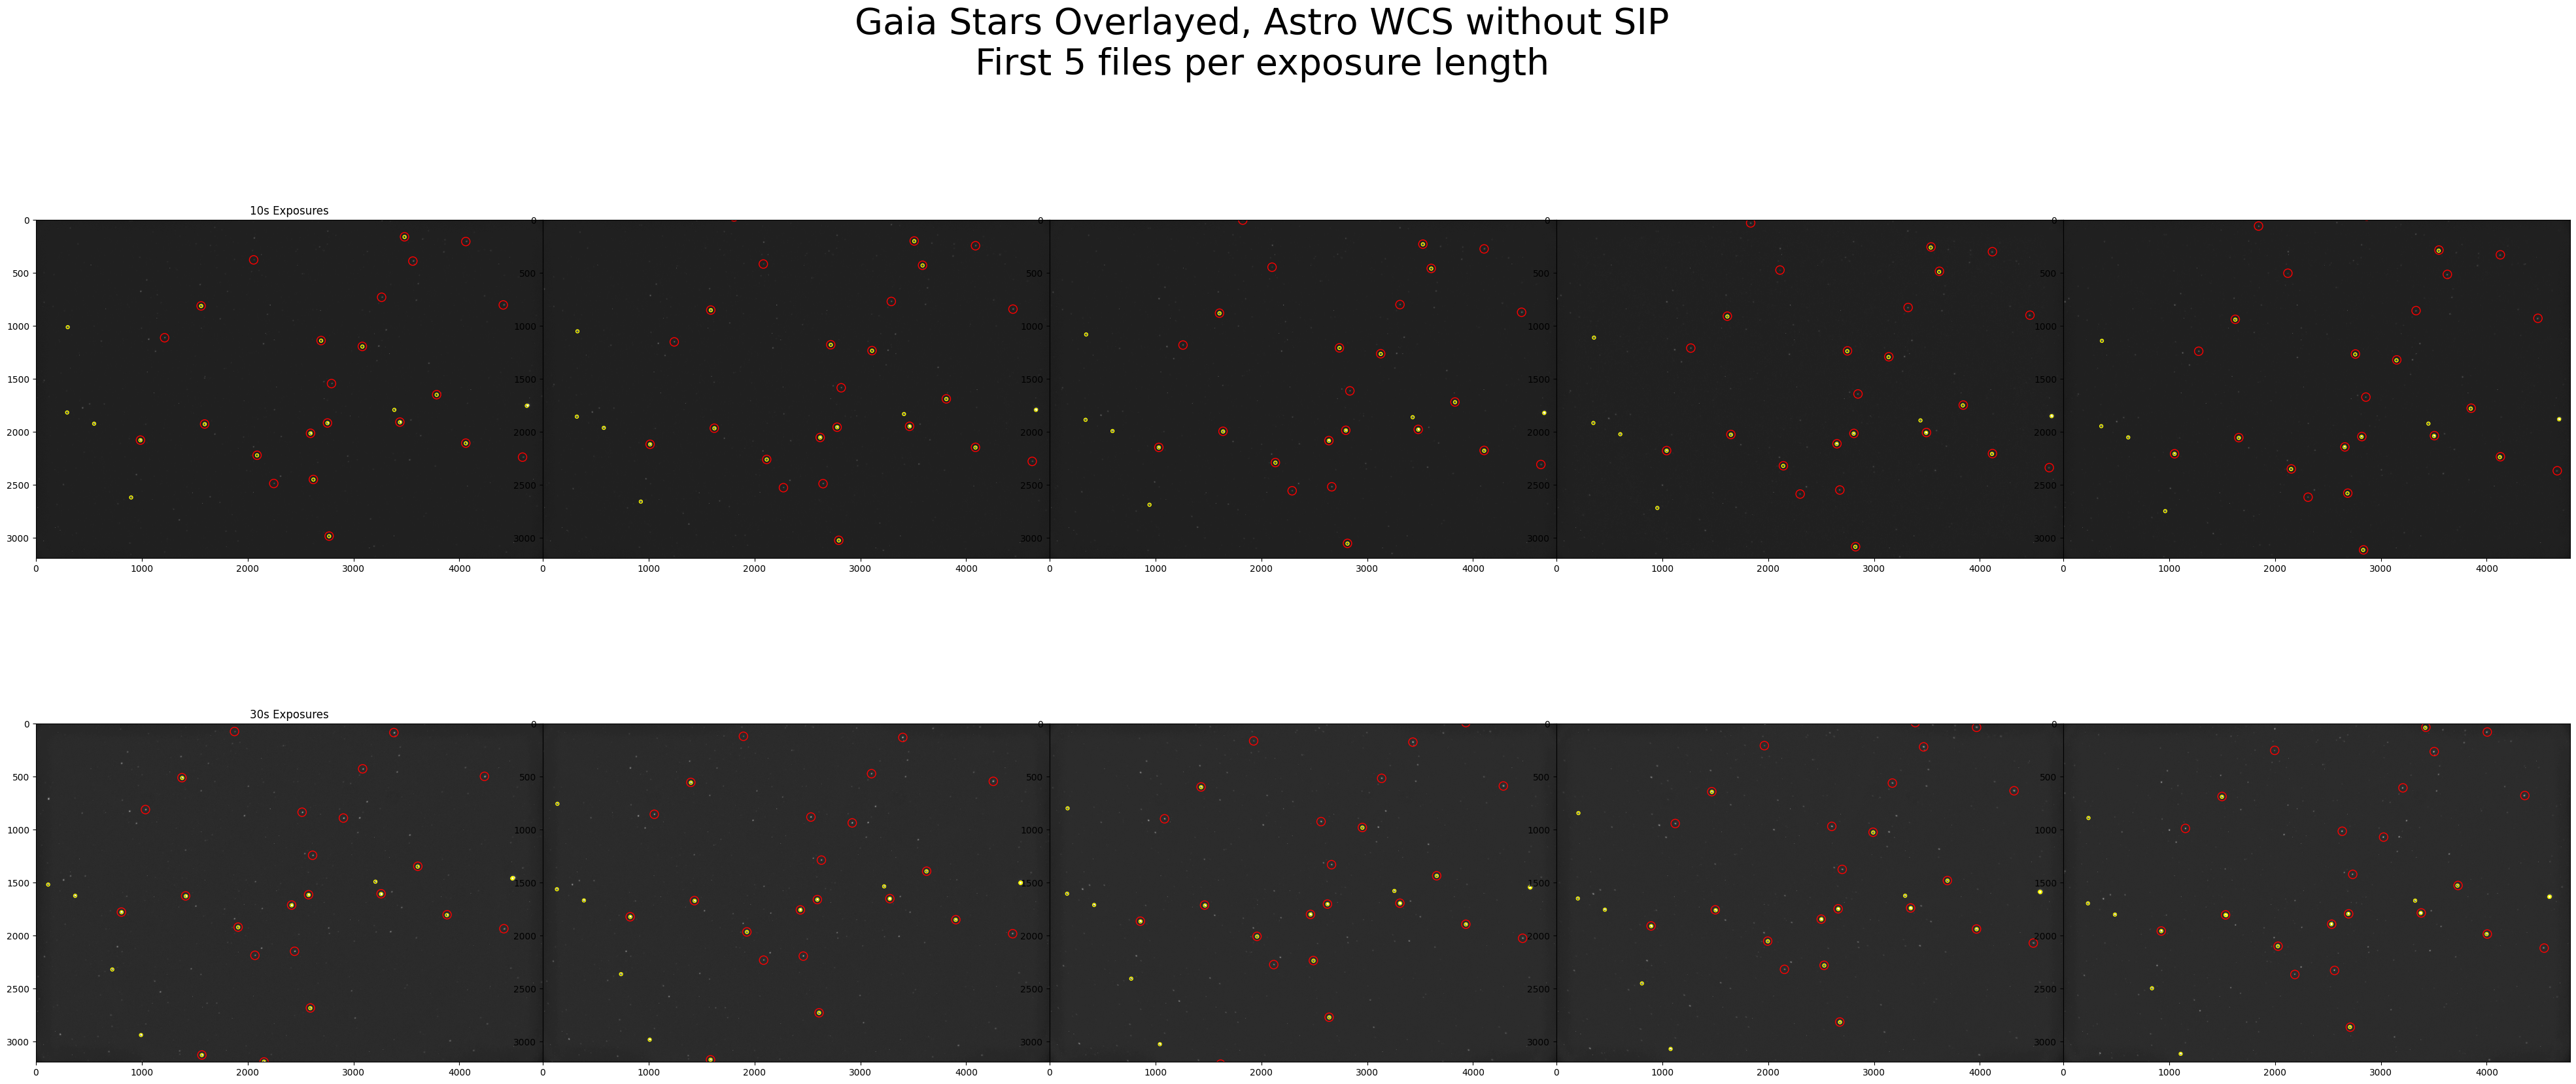

In [54]:
# Create a figure with 2 subplots
fig, ax = plt.subplots(2, 5, figsize=(50, 20))

# Adjust the horizontal spacing
fig.subplots_adjust(wspace=0.0, hspace=0.0)

# Plot the first 5 images from the 10s exposures
plot_images(filenames_10, dataDict_10, tableDict_10, ax[0,:], "10s Exposures")

# Plot the first 5 images from the 30s exposures
plot_images(filenames_30, dataDict_30, tableDict_30, ax[1,:], "30s Exposures")

# Loop through the first 5 filenames
for i, filename in enumerate(filenames_10[:5]):
    # Get the WCS object
    wcs = wcsDict_10_NoSIP[filename]
    # Loop through the Gaia stars
    for radec in radecs:
        # Convert the RA and Dec to pixel coordinates
        x, y = wcs.all_world2pix(radec[0], radec[1], 0)
        # Plot the star using an aperture
        aperture = CircularAperture((x, y), 40)
        aperture.plot(ax[0, i], color="red")

# Loop through the first 5 filenames
for i, filename in enumerate(filenames_30[:5]):
    # Get the WCS object
    wcs = wcsDict_30_NoSIP[filename]
    # Loop through the Gaia stars
    for radec in radecs:
        # Convert the RA and Dec to pixel coordinates
        x, y = wcs.all_world2pix(radec[0], radec[1], 0)
        # Plot the star using an aperture
        aperture = CircularAperture((x, y), 40)
        aperture.plot(ax[1, i], color="red")

# Add Super title
fig.suptitle("Gaia Stars Overlayed, Astro WCS without SIP\nFirst 5 files per exposure length", fontsize=40)
# Show the plot
plt.show()

## Conclusions

It's looking like all the methods worked pretty well. possibly only sending a sources list to astro net made it perform better.
The gaia query tool in twirl is great too!

I think all three methods are viable for generating accurate WCS objects.

## Export WCS Objects

In [58]:
# Export all the wcs objects to fits files and pickle files
wcsPickleFolder = "../Data/VestaData/WCS_Objects/pickles"
wcsFitsFolder = "../Data/VestaData/WCS_Objects/fits"

# Save the files
for filename, wcs in wcsDict_10_SIP.items():
    fits.HDUList([fits.PrimaryHDU(header=wcs.to_header())]).writeto(wcsFitsFolder + "/" + filename + "_SIP.fits", overwrite=True)
    pickle.dump(wcs, open(wcsPickleFolder + "/" + filename + "_SIP.pkl", "wb"))

for filename, wcs in wcsDict_30_SIP.items():
    fits.HDUList([fits.PrimaryHDU(header=wcs.to_header())]).writeto(wcsFitsFolder + "/" + filename + "_SIP.fits", overwrite=True)
    pickle.dump(wcs, open(wcsPickleFolder + "/" + filename + "_SIP.pkl", "wb"))

for filename, wcs in wcsDict_10_NoSIP.items():
    fits.HDUList([fits.PrimaryHDU(header=wcs.to_header())]).writeto(wcsFitsFolder + "/" + filename + "_NoSIP.fits", overwrite=True)
    pickle.dump(wcs, open(wcsPickleFolder + "/" + filename + "_NoSIP.pkl", "wb"))

for filename, wcs in wcsDict_30_NoSIP.items():
    fits.HDUList([fits.PrimaryHDU(header=wcs.to_header())]).writeto(wcsFitsFolder + "/" + filename + "_NoSIP.fits", overwrite=True)
    pickle.dump(wcs, open(wcsPickleFolder + "/" + filename + "_NoSIP.pkl", "wb"))

# twirl WCS too
for filename, wcs in twirlWCSDict_10.items():
    fits.HDUList([fits.PrimaryHDU(header=wcs.to_header())]).writeto(wcsFitsFolder + "/" + filename + "_twirl.fits", overwrite=True)
    pickle.dump(wcs, open(wcsPickleFolder + "/" + filename + "_twirl.pkl", "wb"))

for filename, wcs in twirlWCSDict_30.items():
    fits.HDUList([fits.PrimaryHDU(header=wcs.to_header())]).writeto(wcsFitsFolder + "/" + filename + "_twirl.fits", overwrite=True)
    pickle.dump(wcs, open(wcsPickleFolder + "/" + filename + "_twirl.pkl", "wb"))

## Calculating WCS object accuracy

In [11]:
# Create a function that applies astroalign to a dictionary of filenames to astro images
# takes dictionary, aligns all images to the first image using :
# aligned_image, footprint = register(to_be_aligned, reference)
# returns a dictionary of aligned images
def alignImages(dataDict):
    # Create a dictionary to store the aligned images
    alignedDict = {}
    # Also create a dict of inverse transforms to get original point locations back
    inverseDict = {}
    # Get the first image
    firstImage = dataDict[list(dataDict.keys())[0]]
    # Loop through the data dictionary
    for filename, data in dataDict.items():
        # Align the image
        aligned_image, _ = register(data, firstImage)
        # We also want to get the transformation matrix from the aligned image back to the original image
        # because our WCS objects only work on the original images
        inverse_transform, _ = find_transform(aligned_image, data)
        # Add the aligned image to the dictionary
        alignedDict[filename] = aligned_image
        # Add the inverse transform to the dictionary
        inverseDict[filename] = inverse_transform
    # Return the aligned dictionary
    return alignedDict, inverseDict

In [12]:
# Align the images using astro align
alignedDataDict_10, inverseTransforms_10 = alignImages(dataDict_10)
alignedDataDict_30, inverseTransforms_30 = alignImages(dataDict_30)

In [13]:
# Generate the DAO star finder sources for each image, this time keep all the sources
# Use the same parameters as before

# Apply DAOStarFinder to the images
tableDict_10_All = applyDAOStarFinder(alignedDataDict_10)
tableDict_30_All = applyDAOStarFinder(alignedDataDict_30)

In [16]:
# Print the length of the sources list for each image
print("10s Exposure Sources Number of Sources")
for filename, sources in tableDict_10_All.items():
    print(f"{filename}: {len(sources)}")
print("30s Exposure Sources Number of Sources")
for filename, sources in tableDict_30_All.items():
    print(f"{filename}: {len(sources)}")

10s Exposure Sources Number of Sources
vesta-0831-10.fit: 278
vesta-0835-10.fit: 352
vesta-0838-10.fit: 332
vesta-0841-10.fit: 332
vesta-0844-10.fit: 351
vesta-0847-10.fit: 333
vesta-0850-10.fit: 308
vesta-0853-10.fit: 303
vesta-0858-10.fit: 328
30s Exposure Sources Number of Sources
vesta-0758-30.fit: 294
vesta-0803-30.fit: 371
vesta-0808-30.fit: 338
vesta-0813-30.fit: 279
vesta-0818-30.fit: 378
vesta-0823-30.fit: 279
vesta-0828-30.fit: 274
vesta-0833-30.fit: 251


In [17]:
# We need to be able to link between all the sources found in each image.
# The found sources for each image may not be the same in number, and may not be in the same order
# Need to link them by their x and y centroid positions
# I think the images are closely aligned, but may not be perfectly aligned
# I want the set of points found in all images and links between the list of sources in each image, like 
# a list of indices, where at each index position, corresponding to the source in the first image, is the index of the matching source in the other image
# use the First image as the reference to make a KDTree, and find the closest source in the other images
# Take a dictionary mapping filenames to list of sources in that file
# Return a dicctionary of indices
def linkSources(tableDict, inverseTransformsDict, upper_bound=50):
    # Create a dictionary to store the indices
    indicesDict = {}
    # Get the first table
    refSourcesFileName = list(tableDict.keys())[0]
    firstTable = tableDict[refSourcesFileName]
    # Create a list of all the x and y centroid positions
    xy = np.column_stack((firstTable["xcentroid"], firstTable["ycentroid"]))
    # Create a KDTree
    tree = KDTree(xy)
    # Loop through the tables
    for filename, table in tableDict.items():
        # Create a list to store the indices
        indices = []
        # Loop through the sources
        for source in table:
            # Find the closest source in the first table
            _, index = tree.query((source["xcentroid"], source["ycentroid"]), distance_upper_bound=upper_bound)
            # Add the index to the list
            indices.append(index)
        # Add the list of indices to the dictionary
        indicesDict[filename] = indices
    # Construct set of indices in the ref image that are linked in all images
    all_indices = set(indicesDict[list(indicesDict.keys())[0]])
    print(f"length of all_indices: {len(all_indices)}")
    for indices in indicesDict.values():
        all_indices.intersection_update(indices)
        print(f" Updated length of all_indices: {len(all_indices)}")
    # Modify the indices dictionary to only include the indices that are in all images
    # if an index is not in all images, set it to -1
    for filename in indicesDict:
        indicesDict[filename] = [index if index in all_indices else -1 for index in indicesDict[filename]]

    print(f"Reference image: {refSourcesFileName}")
    print(f"Ref indices list: {indicesDict[refSourcesFileName]}")

    # Now we need to shorten our sources list by removing the unused values
    # as well as reorder the non-reference source lists to match the order of the reference list
    # Start by creating a mappaing of the indices in the reference list if the -1 values are removed
    # to the indices in the original reference list
    trimmedRefIndices = []
    for index in indicesDict[refSourcesFileName]:
        if index != -1:
            trimmedRefIndices.append(index)
    # Create a mapping of the original index to the new index
    indexMapping = {}
    for i, index in enumerate(trimmedRefIndices):
        indexMapping[index] = i
    
    # Now we build a new source table for each image
    # For the Reference image, we use the list of trimmedRefIndices, which should already be in order
    # For the other images, we do the following:
        # Start by creating a list of the same length as the trimmedRefIndices list, but filled with None
        # enumerate the images indices list, so that we know the position of the index in the original list
        # if the index is -1, we skip it
        # if the index is not -1, we use the indexMapping to get the new index
        # We then add the source from the original list, selected by the location of the index in the original list
        # to the new list, at the position from the mapping
        # Once we have gone through all the indices, make sure the new list is the same length as the trimmedRefIndices list
        # and that there are no None values
        # Then convert the list back into an astropy table like the original sources data
    # Return a dictionary of the new source tables
    newTableDict = {}
    for filename, table in tableDict.items():
        indices = indicesDict[filename]
        newSources = [None] * len(trimmedRefIndices)
        for (index, source) in zip(indices, table):
            if index == -1:
                continue
            newIndex = indexMapping[index]
            # Transform the source position from aligned image to original image
            # Must get xcentroid and ycentroid from source row in table
            x = source["xcentroid"]
            y = source["ycentroid"]
            inv_transform = inverseTransformsDict[filename]
            orig_xy = matrix_transform((x, y), inv_transform.params)[0]
            # update source with new x and y
            source["xcentroid"] = orig_xy[0]
            source["ycentroid"] = orig_xy[1]
            newSources[newIndex] = source
        assert all([source is not None for source in newSources])
        newTableDict[filename] = Table(rows=newSources,names=newSources[0].colnames)

    return newTableDict, refSourcesFileName

In [18]:
# Apply the linking function to the tables
linkedSourcesDict_10, refFileName_10 = linkSources(tableDict_10_All, inverseTransforms_10)
linekdSourcesDict_30, refFileName_30 = linkSources(tableDict_30_All, inverseTransforms_30)

length of all_indices: 278
 Updated length of all_indices: 278
 Updated length of all_indices: 255
 Updated length of all_indices: 240
 Updated length of all_indices: 240
 Updated length of all_indices: 231
 Updated length of all_indices: 223
 Updated length of all_indices: 212
 Updated length of all_indices: 204
 Updated length of all_indices: 200
Reference image: vesta-0831-10.fit
Ref indices list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -1, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, -1, 60, 61, 62, 63, 64, 65, 66, 67, 68, -1, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, -1, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, -1, 96, 97, 98, 99, 100, 101, 102, -1, 104, 105, 106, 107, 108, 109, 110, -1, 112, 113, -1, 115, -1, 117, 118, -1, 120, 121, 122, 123, 124, 125, 126, -1, 128, -1, 130, 131, 132, -1, -1, 135, 136, 137, 138, 139, 140, -1, 142, 

In [19]:
# print the sources from the reference image
# also print the length of each table to make sure they are the same
print("10s Exposure Linked Sources")
print(linkedSourcesDict_10[refFileName_10])
for filename, table in linkedSourcesDict_10.items():
    print(f"{filename}: {len(table)}")
print("30s Exposure Linked Sources")
print(linekdSourcesDict_30[refFileName_30])
for filename, table in linekdSourcesDict_30.items():
    print(f"{filename}: {len(table)}")

10s Exposure Linked Sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
157  4637.642060847544 ... 1197.0264129581951     -7.695259333567066
178  3438.889803025549 ...  655.8734927609045     -7.042050197927846
187 2594.2506345924467 ... 426.40123909251633     -6.574546145125209
179  2754.425514662555 ... 316.71867787984775     -6.251684189539354
194  987.3984942607029 ... 247.41987504346233     -5.983586458069135
180  549.8073500949694 ...   96.9918853026757    -4.9668385027870405
 81 1561.0637364951526 ...  76.90713296049503     -4.714916553720776
198  4061.301326598973 ...   76.5284991657192      -4.70955799067899
181 1594.7505374671173 ...  73.25751962288808     -4.662130525231332
165 3385.7965900029644 ...  61.62083417438267       -4.4743189328945
...                ... ...                ...                    ...
136 1944.2923875233375 ... 1.2010320011900038   -0.19888644805572014
169  1

In [20]:
# Load other WCS objects, dict from pickle
folder = "../Data/VestaData/WCS_Objects/"
wcsManual_10 = pickle.load(open(folder + "WCSlog10.pickle", "rb"))
wcsManual_30 = pickle.load(open(folder + "WCSlog30.pickle", "rb"))
wcsAstro_10 = pickle.load(open(folder + "WCSdict_Astro_10.pickle", "rb"))
wcsAstro_30 = pickle.load(open(folder + "WCSdict_Astro_30.pickle", "rb"))
folder = "../Data/VestaData/WCS_Objects/pickles"
# recreate WCS dict from individual pickle files
# remove end of filename after ".fit" to get the original filename
wcsTwirl_10 = {}
wcsTwirl_30 = {}
wcsSip_10 = {}
wcsSip_30 = {}
wcsNoSip_10 = {}
wcsNoSip_30 = {}
for filename in listdir(folder):
    if filename.endswith(".pkl"):
        wcs = pickle.load(open(folder + "/" + filename, "rb"))
        if "twirl" in filename:
            if "10" in filename:
                wcsTwirl_10[filename[:-10]] = wcs
            else:
                wcsTwirl_30[filename[:-10]] = wcs
        elif "_NoSIP" in filename:
            if "10" in filename:
                wcsNoSip_10[filename[:-10]] = wcs
            else:
                wcsNoSip_30[filename[:-10]] = wcs
        else:
            if "10" in filename:
                wcsSip_10[filename[:-8]] = wcs
            else:
                wcsSip_30[filename[:-8]] = wcs

In [21]:
# Query gaia using twirl gaia_radecs to get all the gaia stars covering the field
# Use the first metadata row to get the center
metadataRow = metaData_10.iloc[0]
center = SkyCoord(metadataRow["RA"], metadataRow["DEC"], unit=(Unit("hourangle"), Unit("degree")))
# Query Gaia for star positions
radecs = gaia_radecs(center, 1.0)

# Convert the radecs to a numpy array using the wcs of the ref file
wcs_10 = wcsTwirl_10[refFileName_10]
wcs_30 = wcsTwirl_30[refFileName_30]

xy = []
for radec in radecs:
    x, y = wcs_10.all_world2pix(radec[0], radec[1], 0)
    xy.append((x, y))
gaiaStars_xy_10 = np.array(xy)

xy = []
for radec in radecs:
    x, y = wcs_30.all_world2pix(radec[0], radec[1], 0)
    xy.append((x, y))
gaiaStars_xy_30 = np.array(xy)

In [22]:
# Construct an empty array for the gaia stars matching our sources in the reference image, should be the same length
# as the sources in the reference image
gaiaStars_ref_10 = np.zeros((len(linkedSourcesDict_10[refFileName_10]), 2))
gaiaStars_ref_30 = np.zeros((len(linekdSourcesDict_30[refFileName_30]), 2))
# also make a list of the distances between gaia stars and sources of the same length
gaiaDistances_10 = np.zeros(len(linkedSourcesDict_10[refFileName_10]))
gaiaDistances_30 = np.zeros(len(linekdSourcesDict_30[refFileName_30]))
# Loop through the sources in the refernceimage, find the closest gaia star in the xy array
# and add it to the gaiaStars array
# We can use the KDTree to find the closest star
tree = KDTree(gaiaStars_xy_10)
max_dist = 0
for i, source in enumerate(linkedSourcesDict_10[refFileName_10]):
    x = source["xcentroid"]
    y = source["ycentroid"]
    dist, index = tree.query((x, y), distance_upper_bound=30)
    if index != len(gaiaStars_xy_10):
        if dist > max_dist:
            max_dist = dist
        # inverse transform the xy positions to rA and Dec
        gaiaStars_ref_10[i] = wcsTwirl_10[refFileName_10].all_pix2world(x, y, 0)
        gaiaDistances_10[i] = dist
print(f"Max Gaia star distance from source in pixels, 10s: {max_dist}")

tree = KDTree(gaiaStars_xy_30)
max_dist = 0
for i, source in enumerate(linekdSourcesDict_30[refFileName_30]):
    x = source["xcentroid"]
    y = source["ycentroid"]
    dist, index = tree.query((x, y), distance_upper_bound=30)
    if index != len(gaiaStars_xy_30):
        if dist > max_dist:
            max_dist = dist
        # inverse transform the xy positions to rA and Dec
        gaiaStars_ref_30[i] = wcsTwirl_30[refFileName_30].all_pix2world(x, y, 0)
        gaiaDistances_30[i] = dist
print(f"Max Gaia star distance from source in pixels, 30s: {max_dist}")

Max Gaia star distance from source in pixels, 10s: 3.791391878439635
Max Gaia star distance from source in pixels, 30s: 2.619318050219507


### Note! If no matching Gaia star was found, then its position is 0,0, and must be excluded from the accuracy measurement!

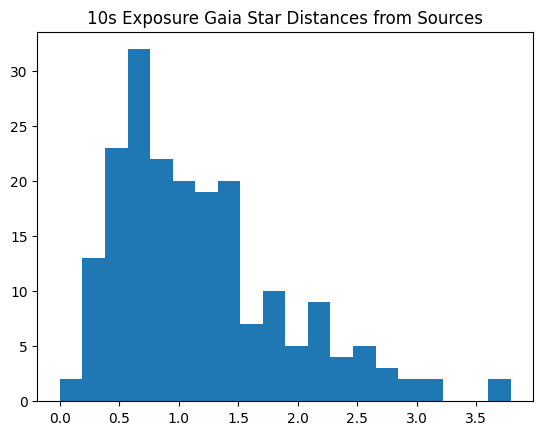

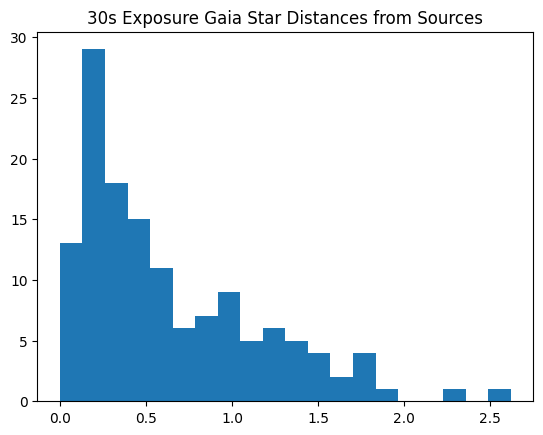

In [100]:
#plot hist of distances
plt.hist(gaiaDistances_10, bins=20)
plt.title("10s Exposure Gaia Star Distances from Sources")
plt.show()
plt.hist(gaiaDistances_30, bins=20)
plt.title("30s Exposure Gaia Star Distances from Sources")
plt.show()

In [101]:
# Print the first 5 gaia stars in each array
# print the length of each array, make sure it matches the length or sources in the reference image
print("10s Exposure Gaia Stars")
print(gaiaStars_ref_10[:5])
print(len(gaiaStars_ref_10))
print("30s Exposure Gaia Stars")
print(gaiaStars_ref_30[:5])
print(len(gaiaStars_ref_30))

10s Exposure Gaia Stars
[[ 0.          0.        ]
 [85.04967285 23.99469732]
 [85.14933432 23.98307719]
 [85.13046236 23.99360284]
 [85.33895073 23.9754735 ]]
200
30s Exposure Gaia Stars
[[85.04956757 23.99465764]
 [85.14919221 23.98302136]
 [ 0.          0.        ]
 [85.13032971 23.99356628]
 [85.33877746 23.9753479 ]]
137


# Finally
We have a list of star sources, ordered, linked between each image for each exposure type, 
We also have a list of gaia stars that correspond to those stars, and their RA Dec in degrees
Now we can put each of these Gaia stars through each wcs (or other way around) to compare to the other.

In [102]:
# Save the Gaia star dicts and linked sources dicts to pickle files
folder = "../Data/VestaData/AccCalcDicts/"
pickle.dump(gaiaStars_ref_10, open(folder + "gaiaStars_ref_10.pkl", "wb"))
pickle.dump(gaiaStars_ref_30, open(folder + "gaiaStars_ref_30.pkl", "wb"))
pickle.dump(linkedSourcesDict_10, open(folder + "linkedSourcesDict_10.pkl", "wb"))
pickle.dump(linekdSourcesDict_30, open(folder + "linkedSourcesDict_30.pkl", "wb"))

In [4]:
# Load the gaia star dicts and linked sources dicts from pickle files
folder = "../Data/VestaData/AccCalcDicts/"
gaiaStars_ref_10 = pickle.load(open(folder + "gaiaStars_ref_10.pkl", "rb"))
gaiaStars_ref_30 = pickle.load(open(folder + "gaiaStars_ref_30.pkl", "rb"))
linkedSourcesDict_10 = pickle.load(open(folder + "linkedSourcesDict_10.pkl", "rb"))
linekdSourcesDict_30 = pickle.load(open(folder + "linkedSourcesDict_30.pkl", "rb"))

In [29]:
def calculate_errors(linked_sources_dict, gaia_stars_ref, wcs_dicts):
    # Create a dictionary to store the dataframes
    error_dict = {}

    # Loop through the linked sources dictionary
    for filename, sources in linked_sources_dict.items():
        # Create an empty list to store the error data for this filename
        error_data = []

        # Loop through the sources
        for i, source in enumerate(sources):
            # Skip if gaia star has zero coordinates
            if gaia_stars_ref[i][0] == 0 and gaia_stars_ref[i][1] == 0:
                continue

            # Get the x and y centroid positions
            x = source["xcentroid"]
            y = source["ycentroid"]

            # Get the flux of the source
            flux = source["flux"]

            # Initialize a dictionary to store the errors for each WCS type
            row_data = {"Star ID": i, "Star X (pix)": x, "Star Y (pix)": y, "Star Flux": flux}

            # Loop through the WCS dictionaries
            for wcs_name, wcs_dict in wcs_dicts.items():
                # check if wcs_dict has key for filename
                if wcs_dict is None or filename not in wcs_dict:
                    continue
                # Get the WCS object
                wcs = wcs_dict[filename]

                # Get the pixel coordinates of the gaia star
                gaia_xy = wcs.all_world2pix(gaia_stars_ref[i][0], gaia_stars_ref[i][1], 0)

                # Get the RA and Dec of the source
                ra, dec = wcs.all_pix2world(x, y, 0)

                # Calculate the pixel error
                x_err = gaia_xy[0] - x
                y_err = gaia_xy[1] - y

                # Calculate the RA and Dec error
                ra_err = gaia_stars_ref[i][0]*np.cos(np.radians(gaia_stars_ref[i][0])) - ra*np.cos(np.radians(ra))
                dec_err = gaia_stars_ref[i][1] - dec

                # Add the errors to the dictionary
                row_data.update({f"Pixel Error WCS Method {wcs_name}": (x_err**2 + y_err**2)**0.5,
                                  f"RA/Dec Error WCS Method {wcs_name}": ((ra_err**2 + dec_err**2)**0.5) * 3600})  # convert to arcseconds

            # Append the row data to the error data list
            error_data.append(row_data)

        # Create a dataframe from the list and add it to the dictionary
        error_dict[filename] = pd.DataFrame(error_data)

    return error_dict

In [28]:
print(wcsTwirl_10.keys())
print(wcsAstro_10.keys())

dict_keys(['vesta-0831-10.fit', 'vesta-0835-10.fit', 'vesta-0838-10.fit', 'vesta-0841-10.fit', 'vesta-0844-10.fit', 'vesta-0847-10.fit', 'vesta-0850-10.fit', 'vesta-0853-10.fit', 'vesta-0858-10.fit'])
dict_keys(['vesta-0831-10.fit', 'vesta-0838-10.fit', 'vesta-0841-10.fit', 'vesta-0844-10.fit', 'vesta-0847-10.fit', 'vesta-0850-10.fit', 'vesta-0853-10.fit', 'vesta-0858-10.fit'])


In [30]:
# Calculate the errors
wcsDicts = {"Twirl": wcsTwirl_10, "SIP": wcsSip_10, "Web_Astro": wcsAstro_10, "Manual": wcsManual_10}
errorDict_10 = calculate_errors(linkedSourcesDict_10, gaiaStars_ref_10, wcsDicts)

wcsDicts = {"Twirl": wcsTwirl_30, "SIP": wcsSip_30, "Web_Astro": wcsAstro_30, "Manual": wcsManual_30}
errorDict_30 = calculate_errors(linekdSourcesDict_30, gaiaStars_ref_30, wcsDicts)

In [82]:
errorDict_10[list(errorDict_10.keys())[0]]

Star ID  Star X (pix)  Star Y (pix)   Star Flux  \
0          1   3438.889803   1909.440055  655.873493   
1          2   2594.250635   2014.785877  426.401239   
2          3   2754.425515   1917.654082  316.718678   
3          4    987.398494   2079.013808  247.419875   
4          5    549.807350   1923.346136   96.991885   
..       ...           ...           ...         ...   
194      195   2992.666226   2101.516249    1.140838   
195      196    376.987223   2345.212598    1.099606   
196      197   2677.654881   1182.588876    1.077729   
197      198   2049.965154     20.316625    1.004910   
198      199   4551.857238    540.685151    1.000090   

     Pixel Error WCS Method Twirl  RA/Dec Error WCS Method Twirl  \
0                    8.733665e-11                            0.0   
1                    2.033692e-12                            0.0   
2                    1.190633e-10                            0.0   
3                    2.286236e-11                            0.0   
4                    6.563788e-11                            0.0   
..                            ...                            ...   
194                  5.193286e-11                            0.0   
195                  4.533700e-11                            0.0   
196                  7.637353e-11                            0.0   
197                  3.847557e-11                            0.0   
198                  1.090872e-10                            0.0   

     Pixel Error WCS Method SIP  RA/Dec Error WCS Method SIP  \
0                      1.460838                     0.728352   
1                      1.423639                     0.714345   
2                      1.387955                     0.685934   
3                      2.621554                     1.406395   
4                      3.233044                     1.746167   
..                          ...                          ...   
194                    1.402224                     0.710402   
195                    3.574268                     1.971887   
196                    1.292753                     0.604370   
197                    1.228723                     0.657774   
198                    1.858457                     0.956798   

     Pixel Error WCS Method NoSIP  RA/Dec Error WCS Method NoSIP  \
0                        1.926667                       0.965001   
1                        2.047145                       1.042717   
2                        1.998075                       1.014634   
3                        2.232366                       1.167682   
4                        2.224552                       1.171938   
..                            ...                            ...   
194                      2.036386                       1.029550   
195                      2.384607                       1.256671   
196                      1.757530                       0.893354   
197                      1.431187                       0.738113   
198                      1.359769                       0.653291   

     Pixel Error WCS Method Manual  RA/Dec Error WCS Method Manual  
0                         2.254812                        1.004038  
1                         2.923066                        1.139368  
2                         2.796762                        1.087357  
3                         3.856664                        1.823533  
4                         3.960460                        1.994928  
..                             ...                             ...  
194                       2.517953                        0.977595  
195                       3.962890                        2.061177  
196                       3.324568                        1.445114  
197                       3.996527                        1.752687  
198                       7.400593                        4.358168  

[199 rows x 12 columns]

In [31]:
# pickle the error dictionaries into the same folder as the linked sources dict
folder = "../Data/VestaData/AccCalcDicts/"
pickle.dump(errorDict_10, open(folder + "errorDict_10.pkl", "wb"))
pickle.dump(errorDict_30, open(folder + "errorDict_30.pkl", "wb"))
# store each table as a csv in a nested folder "ErrorTables"
errorTablesFolder = folder + "ErrorTables/"
for filename, table in errorDict_10.items():
    table.to_csv(errorTablesFolder + filename + ".csv")
for filename, table in errorDict_30.items():
    table.to_csv(errorTablesFolder + filename + ".csv")